In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import pytz
from numba import njit

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import base_optimizer

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import create_order_nb, sort_call_seq_nb
from vectorbt.portfolio.enums import SizeType, Direction

In [2]:
# Define params
symbols = ['FB', 'AMZN', 'NFLX', 'GOOG', 'AAPL']
start_date = datetime(2017, 1, 1, tzinfo=pytz.utc)
end_date = datetime.utcnow()
num_tests = 2000

vbt.settings.returns['year_freq'] = '252 days'

In [3]:
yfdata = vbt.YFData.download(symbols, start=start_date, end=end_date)

print(yfdata.symbols)

['FB', 'AMZN', 'NFLX', 'GOOG', 'AAPL']


In [4]:
ohlcv = yfdata.concat()

print(ohlcv.keys())

dict_keys(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])


In [5]:
price = ohlcv['Close']

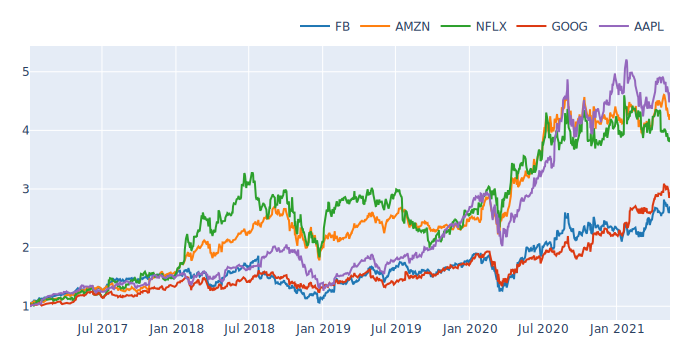

In [6]:
# Plot normalized price series
(price / price.iloc[0]).vbt.plot().show_svg()

In [7]:
returns = price.pct_change()

In [8]:
print(returns.mean())

symbol
FB      0.001137
AMZN    0.001505
NFLX    0.001546
GOOG    0.001139
AAPL    0.001598
dtype: float64


In [9]:
print(returns.std())

symbol
FB      0.021374
AMZN    0.019041
NFLX    0.025100
GOOG    0.017579
AAPL    0.019886
dtype: float64


In [10]:
print(returns.corr())

symbol        FB      AMZN      NFLX      GOOG      AAPL
symbol                                                  
FB      1.000000  0.634853  0.502599  0.696113  0.616256
AMZN    0.634853  1.000000  0.637386  0.676144  0.643882
NFLX    0.502599  0.637386  1.000000  0.540223  0.488485
GOOG    0.696113  0.676144  0.540223  1.000000  0.666463
AAPL    0.616256  0.643882  0.488485  0.666463  1.000000


## vectorbt: Random search

### One-time allocation

In [11]:
np.random.seed(42)

# Generate random weights, n times
weights = []
for i in range(num_tests):
    w = np.random.random_sample(len(symbols))
    w = w / np.sum(w)
    weights.append(w)

print(len(weights))

2000


In [12]:
# Build column hierarchy such that one weight corresponds to one price series
_price = price.vbt.tile(num_tests, keys=pd.Index(np.arange(num_tests), name='symbol_group'))
_price = _price.vbt.stack_index(pd.Index(np.concatenate(weights), name='weights'))

print(_price.columns)

MultiIndex([( 0.13319702814025883,    0,   'FB'),
            ( 0.33810081711389406,    0, 'AMZN'),
            ( 0.26031768763785473,    0, 'NFLX'),
            (  0.2128998389048247,    0, 'GOOG'),
            ( 0.05548462820316767,    0, 'AAPL'),
            ( 0.06528491964469331,    1,   'FB'),
            ( 0.02430844330237927,    1, 'AMZN'),
            (  0.3625014516740258,    1, 'NFLX'),
            (  0.2515713061862386,    1, 'GOOG'),
            ( 0.29633387919266296,    1, 'AAPL'),
            ...
            (  0.2056564359049325, 1998,   'FB'),
            ( 0.14846396871443943, 1998, 'AMZN'),
            ( 0.21512097636364197, 1998, 'NFLX'),
            (  0.3738566007394396, 1998, 'GOOG'),
            (0.056902018277546554, 1998, 'AAPL'),
            ( 0.25860265182212094, 1999,   'FB'),
            (  0.2706191852849979, 1999, 'AMZN'),
            (  0.2854538191129893, 1999, 'NFLX'),
            ( 0.11985160754099378, 1999, 'GOOG'),
            (  0.0654727362388982,

In [13]:
# Define order size
size = np.full_like(_price, np.nan)
size[0, :] = np.concatenate(weights)  # allocate at first timestamp, do nothing afterwards

print(size.shape)

(1099, 10000)


In [14]:
# Run simulation
portfolio = vbt.Portfolio.from_orders(
    close=_price,
    size=size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    freq='D',
    incl_unrealized=True
) # all weights sum to 1, no shorting, and 100% investment in risky assets

print(len(portfolio.orders))

10000


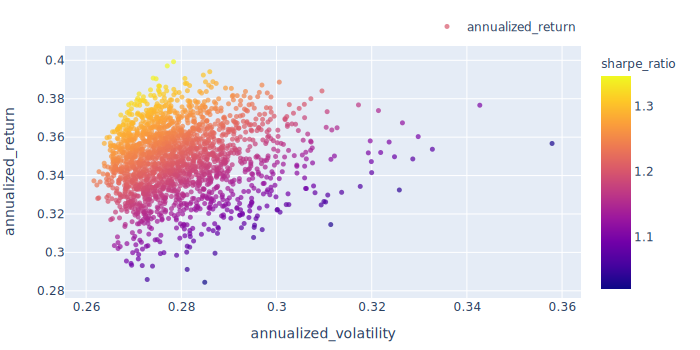

In [15]:
# Plot annualized return against volatility, color by sharpe ratio
annualized_return = portfolio.annualized_return()
annualized_return.index = portfolio.annualized_volatility()
annualized_return.vbt.scatterplot(
    trace_kwargs=dict(
        mode='markers', 
        marker=dict(
            color=portfolio.sharpe_ratio(),
            colorbar=dict(
                title='sharpe_ratio'
            ),
            size=5,
            opacity=0.7
        )
    ),
    xaxis_title='annualized_volatility',
    yaxis_title='annualized_return'
).show_svg()

In [16]:
# Get index of the best group according to the target metric
best_symbol_group = portfolio.sharpe_ratio().idxmax()

print(best_symbol_group)

1920


In [17]:
# Print best weights
print(weights[best_symbol_group])

[0.01154842 0.46529877 0.10296527 0.02644507 0.39374246]


In [18]:
# Compute default stats
print(portfolio.iloc[best_symbol_group].stats())

Start                      2017-01-03 00:00:00+00:00
End                        2021-05-14 00:00:00+00:00
Duration                          1099 days 00:00:00
Init. Cash                                       100
Total Profit                                 332.793
Total Return [%]                             332.793
Benchmark Return [%]                         268.903
Position Coverage [%]                            100
Max. Drawdown [%]                            34.4419
Avg. Drawdown [%]                             3.0656
Max. Drawdown Duration             324 days 00:00:00
Avg. Drawdown Duration    14 days 04:52:10.434782608
Num. Trades                                        5
Win Rate [%]                                     100
Best Trade [%]                               364.919
Worst Trade [%]                              170.358
Avg. Trade [%]                               268.903
Max. Trade Duration               1098 days 00:00:00
Avg. Trade Duration               1098 days 00

### Rebalance monthly

In [19]:
# Select the first index of each month
rb_mask = ~_price.index.to_period('m').duplicated()

print(rb_mask.sum())

53


/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1091: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [20]:
rb_size = np.full_like(_price, np.nan)
rb_size[rb_mask, :] = np.concatenate(weights)  # allocate at mask

print(rb_size.shape)

(1099, 10000)


In [21]:
# Run simulation, with rebalancing monthly
rb_portfolio = vbt.Portfolio.from_orders(
    close=_price,
    size=rb_size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    call_seq='auto',  # important: sell before buy
    freq='D',
    incl_unrealized=True
)

print(len(rb_portfolio.orders))

529993


In [22]:
rb_best_symbol_group = portfolio.sharpe_ratio().idxmax()

print(rb_best_symbol_group)

1920


In [23]:
print(weights[rb_best_symbol_group])

[0.01154842 0.46529877 0.10296527 0.02644507 0.39374246]


In [24]:
print(rb_portfolio.iloc[rb_best_symbol_group].stats())

Start                       2017-01-03 00:00:00+00:00
End                         2021-05-14 00:00:00+00:00
Duration                           1099 days 00:00:00
Init. Cash                                        100
Total Profit                                  352.791
Total Return [%]                              352.791
Benchmark Return [%]                          268.903
Position Coverage [%]                             100
Max. Drawdown [%]                             33.6883
Avg. Drawdown [%]                             2.94252
Max. Drawdown Duration              304 days 00:00:00
Avg. Drawdown Duration     13 days 04:32:25.945945946
Num. Trades                                       124
Win Rate [%]                                  99.1935
Best Trade [%]                                249.176
Worst Trade [%]                              -7.13426
Avg. Trade [%]                                68.3847
Max. Trade Duration                1098 days 00:00:00
Avg. Trade Duration       57

In [25]:
def plot_allocation(rb_portfolio):
    # Plot weights development of the portfolio
    rb_holding_value = rb_portfolio.holding_value(group_by=False)
    rb_value = rb_portfolio.value()
    rb_idxs = np.flatnonzero((rb_portfolio.share_flow() != 0).any(axis=1))
    rb_dates = rb_portfolio.wrapper.index[rb_idxs]
    fig = (rb_holding_value.vbt / rb_value).vbt.plot(
        trace_names=symbols,
        trace_kwargs=dict(
            stackgroup='one'
        )
    )
    for rb_date in rb_dates:
        fig.add_shape(
            dict(
                xref='x',
                yref='paper',
                x0=rb_date,
                x1=rb_date,
                y0=0,
                y1=1,
                line_color=fig.layout.template.layout.plot_bgcolor
            )
        )
    fig.show_svg()

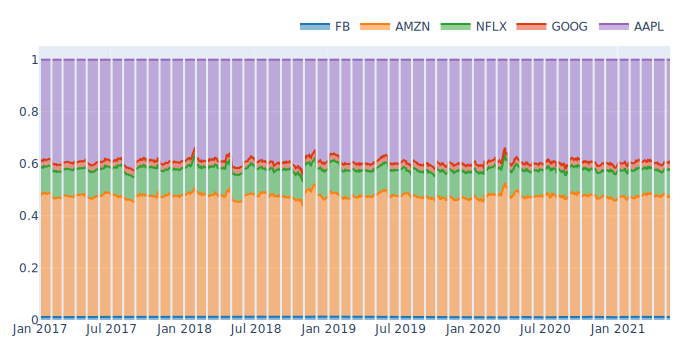

In [26]:
plot_allocation(rb_portfolio.iloc[rb_best_symbol_group])  # best group

### Search and rebalance every 30 days

Utilize low-level API to dynamically search for best Sharpe ratio and rebalance accordingly. Compared to previous method, we won't utilize stacking, but do search in a loop instead. We also will use days instead of months, as latter may contain a various number of trading days.

In [27]:
srb_sharpe = np.full(price.shape[0], np.nan)

@njit
def prep_func_nb(c, every_nth):
    # Define rebalancing days
    c.active_mask[:, :] = False
    c.active_mask[every_nth::every_nth, :] = True
    return ()

@njit
def find_weights_nb(c, price, num_tests):
    # Find optimal weights based on best Sharpe ratio
    returns = (price[1:] - price[:-1]) / price[:-1]
    returns = returns[1:, :]  # cannot compute np.cov with NaN
    mean = nanmean_nb(returns)
    cov = np.cov(returns, rowvar=False)  # masked arrays not supported by Numba (yet)
    best_sharpe_ratio = -np.inf
    
    for i in range(num_tests):
        # Generate weights
        w = np.random.random_sample(c.group_len)
        w = w / np.sum(w)
        
        # Compute annualized mean, covariance, and Sharpe ratio
        p_return = np.sum(mean * w) * ann_factor
        p_std = np.sqrt(np.dot(w.T, np.dot(cov, w))) * np.sqrt(ann_factor)
        sharpe_ratio = p_return / p_std
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            weights = w
            
    return best_sharpe_ratio, weights

@njit
def segment_prep_func_nb(c, find_weights_nb, history_len, ann_factor, num_tests, srb_sharpe):
    if history_len == -1:
        # Look back at the entire time period
        close = c.close[:c.i, c.from_col:c.to_col]
    else:
        # Look back at a fixed time period
        if c.i - history_len <= 0:
            return (np.full(c.group_len, np.nan),)  # insufficient data
        close = c.close[c.i - history_len:c.i, c.from_col:c.to_col]
    
    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(c, close, num_tests)
    srb_sharpe[c.i] = best_sharpe_ratio
        
    # Update valuation price and reorder orders
    size_type = SizeType.TargetPercent
    direction = Direction.LongOnly
    order_value_out = np.empty(c.group_len, dtype=np.float_)
    for k in range(c.group_len):
        col = c.from_col + k
        c.last_val_price[col] = c.close[c.i, col]
    sort_call_seq_nb(c, weights, size_type, direction, order_value_out)
    
    return (weights,)

@njit
def order_func_nb(c, weights):
    col_i = c.call_seq_now[c.call_idx]
    return create_order_nb(
        size=weights[col_i], 
        size_type=SizeType.TargetPercent, 
        price=c.close[c.i, c.col]
    )

In [28]:
ann_factor = returns.vbt.returns(freq='D').ann_factor

In [29]:
# Run simulation using a custom order function
srb_portfolio = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    prep_func_nb=prep_func_nb,
    prep_args=(30,),
    segment_prep_func_nb=segment_prep_func_nb,
    segment_prep_args=(find_weights_nb, -1, ann_factor, num_tests, srb_sharpe),
    cash_sharing=True, 
    group_by=True,
    freq='D',
    incl_unrealized=True,
    seed=42
)

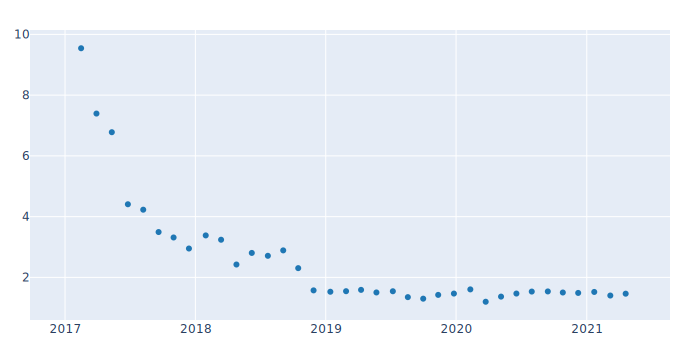

In [30]:
# Plot best Sharpe ratio at each rebalancing day
pd.Series(srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [31]:
print(srb_portfolio.stats())

Start                       2017-01-03 00:00:00+00:00
End                         2021-05-14 00:00:00+00:00
Duration                           1099 days 00:00:00
Init. Cash                                        100
Total Profit                                  196.899
Total Return [%]                              196.899
Benchmark Return [%]                          268.903
Position Coverage [%]                         97.2702
Max. Drawdown [%]                             34.3509
Avg. Drawdown [%]                             3.44458
Max. Drawdown Duration              311 days 00:00:00
Avg. Drawdown Duration     16 days 07:04:55.081967213
Num. Trades                                        95
Win Rate [%]                                  81.0526
Best Trade [%]                                77.0805
Worst Trade [%]                              -23.7438
Avg. Trade [%]                                13.6208
Max. Trade Duration                1068 days 00:00:00
Avg. Trade Duration       55

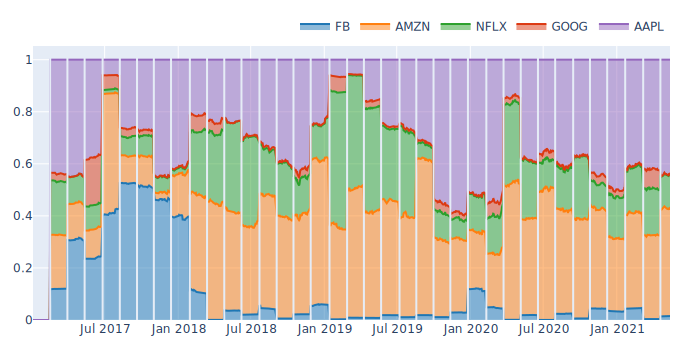

In [32]:
plot_allocation(srb_portfolio)

You can see how weights stabilize themselves with growing data.

In [33]:
# Run simulation, but now consider only the last 252 days of data
srb252_sharpe = np.full(price.shape[0], np.nan)

srb252_portfolio = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    prep_func_nb=prep_func_nb,
    prep_args=(30,),
    segment_prep_func_nb=segment_prep_func_nb,
    segment_prep_args=(find_weights_nb, 252, ann_factor, num_tests, srb252_sharpe),
    cash_sharing=True, 
    group_by=True,
    freq='D',
    incl_unrealized=True,
    seed=42
)

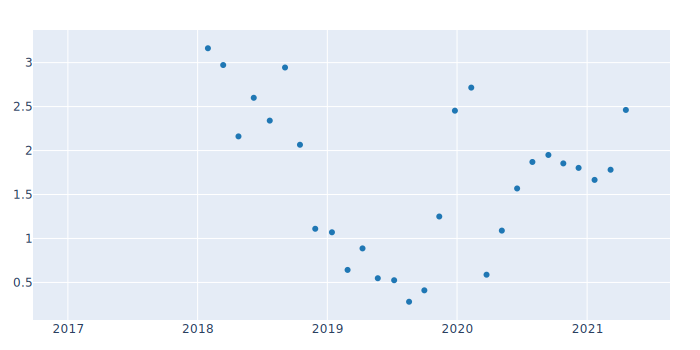

In [34]:
pd.Series(srb252_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [35]:
print(srb252_portfolio.stats())

Start                       2017-01-03 00:00:00+00:00
End                         2021-05-14 00:00:00+00:00
Duration                           1099 days 00:00:00
Init. Cash                                        100
Total Profit                                  131.137
Total Return [%]                              131.137
Benchmark Return [%]                          268.903
Position Coverage [%]                         75.4322
Max. Drawdown [%]                              33.136
Avg. Drawdown [%]                             4.20331
Max. Drawdown Duration              193 days 00:00:00
Avg. Drawdown Duration               16 days 00:00:00
Num. Trades                                        65
Win Rate [%]                                  70.7692
Best Trade [%]                                89.0979
Worst Trade [%]                              -15.5016
Avg. Trade [%]                                9.26772
Max. Trade Duration                 828 days 00:00:00
Avg. Trade Duration       46

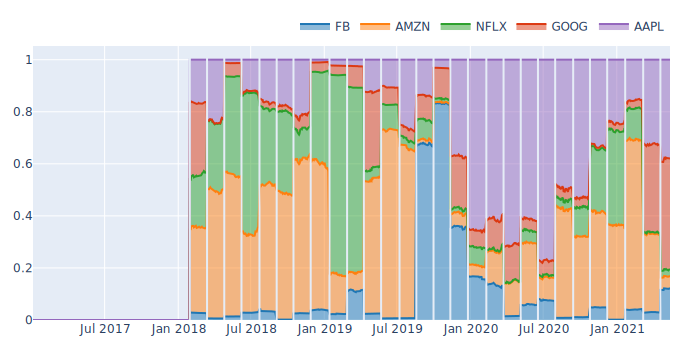

In [36]:
plot_allocation(srb252_portfolio)

A much more volatile weight distribution.

## PyPortfolioOpt + vectorbt

### One-time allocation

In [37]:
# Calculate expected returns and sample covariance amtrix
avg_returns = expected_returns.mean_historical_return(price)
cov_mat = risk_models.sample_cov(price)

# Get weights maximizing the Sharpe ratio
ef = EfficientFrontier(avg_returns, cov_mat)
weights = ef.max_sharpe()
clean_weights = ef.clean_weights()
pyopt_weights = np.array([clean_weights[symbol] for symbol in symbols])

print(pyopt_weights)

[0.      0.47545 0.00686 0.      0.51768]


In [38]:
pyopt_size = np.full_like(price, np.nan)
pyopt_size[0, :] = pyopt_weights  # allocate at first timestamp, do nothing afterwards

print(pyopt_size.shape)

(1099, 5)


In [39]:
# Run simulation with weights from PyPortfolioOpt
pyopt_portfolio = vbt.Portfolio.from_orders(
    close=price,
    size=pyopt_size,
    size_type='targetpercent',
    group_by=True,
    cash_sharing=True,
    freq='D',
    incl_unrealized=True
)

print(len(pyopt_portfolio.orders))

3


Faster than stacking solution, but doesn't let you compare weights.

In [40]:
print(pyopt_portfolio.stats())

Start                      2017-01-03 00:00:00+00:00
End                        2021-05-14 00:00:00+00:00
Duration                          1099 days 00:00:00
Init. Cash                                       100
Total Profit                                 346.651
Total Return [%]                             346.651
Benchmark Return [%]                         268.903
Position Coverage [%]                             60
Max. Drawdown [%]                            34.7279
Avg. Drawdown [%]                            3.01796
Max. Drawdown Duration             297 days 00:00:00
Avg. Drawdown Duration    13 days 11:50:08.219178082
Num. Trades                                        3
Win Rate [%]                                     100
Best Trade [%]                               364.919
Worst Trade [%]                              286.987
Avg. Trade [%]                               326.511
Max. Trade Duration               1098 days 00:00:00
Avg. Trade Duration               1098 days 00

### Search and rebalance monthly

You can't use third-party optimization packages within Numba (yet).

Here you have two choices:
1) Use `os.environ['NUMBA_DISABLE_JIT'] = '1'` before all imports to disable Numba completely
2) Disable Numba for the function, but also for every other function in the stack that calls it

We will demonstrate the second option.

In [41]:
def pyopt_find_weights(sc, price, num_tests):  # no @njit decorator = it's a pure Python function
    # Calculate expected returns and sample covariance matrix
    price = pd.DataFrame(price, columns=symbols)
    avg_returns = expected_returns.mean_historical_return(price)
    cov_mat = risk_models.sample_cov(price)

    # Get weights maximizing the Sharpe ratio
    ef = EfficientFrontier(avg_returns, cov_mat)
    weights = ef.max_sharpe()
    clean_weights = ef.clean_weights()
    weights = np.array([clean_weights[symbol] for symbol in symbols])
    best_sharpe_ratio = base_optimizer.portfolio_performance(weights, avg_returns, cov_mat)[2]
            
    return best_sharpe_ratio, weights

In [42]:
pyopt_srb_sharpe = np.full(price.shape[0], np.nan)

# Run simulation with a custom order function
pyopt_srb_portfolio = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    prep_func_nb=prep_func_nb,
    prep_args=(30,),
    segment_prep_func_nb=segment_prep_func_nb.py_func,  # run segment_prep_func_nb as pure Python function
    segment_prep_args=(pyopt_find_weights, -1, ann_factor, num_tests, pyopt_srb_sharpe),
    cash_sharing=True, 
    group_by=True,
    freq='D',
    incl_unrealized=True,
    seed=42,
    use_numba=False  # run simulate_nb as pure Python function
)

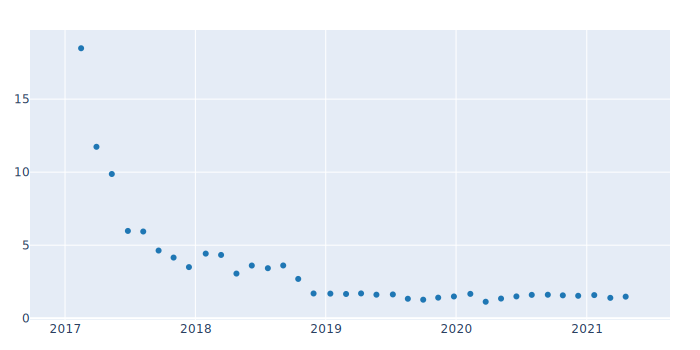

In [43]:
pd.Series(pyopt_srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [44]:
print(pyopt_srb_portfolio.stats())

Start                       2017-01-03 00:00:00+00:00
End                         2021-05-14 00:00:00+00:00
Duration                           1099 days 00:00:00
Init. Cash                                        100
Total Profit                                  167.385
Total Return [%]                              167.385
Benchmark Return [%]                          268.903
Position Coverage [%]                         57.8162
Max. Drawdown [%]                             35.3639
Avg. Drawdown [%]                             3.80372
Max. Drawdown Duration              348 days 00:00:00
Avg. Drawdown Duration     18 days 00:51:25.714285714
Num. Trades                                        62
Win Rate [%]                                  85.4839
Best Trade [%]                                65.4084
Worst Trade [%]                              -30.6354
Avg. Trade [%]                                17.0445
Max. Trade Duration                 858 days 00:00:00
Avg. Trade Duration       26

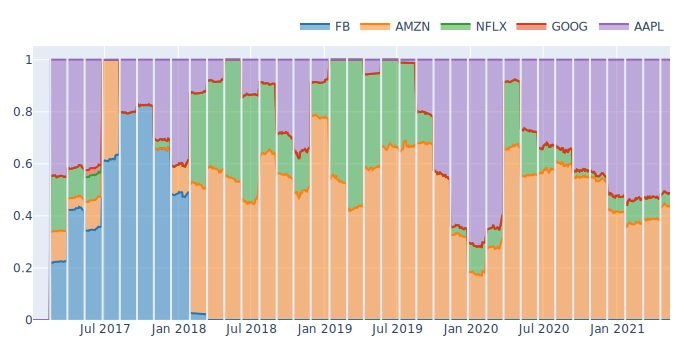

In [45]:
plot_allocation(pyopt_srb_portfolio)